In [1]:
import numpy as np
import faiss
import json
from tqdm import tqdm
from augmentation import TfIdfAugmentation
from tools.utils import ExternalPreprocessor

In [2]:
VOCAB_PATH = '../routing/data/sberbank_embeddings/w2v_m5_w3_v300_norm_v48_vocab.txt'
W2V_MATRIX_PATH = '../routing/data/sberbank_embeddings/w2v_m5_w3_v300_norm_v48_vectors.npy'

In [3]:
with open('token2prob.json') as f:
    token2prob = json.loads(f.read())

In [4]:
augmentator = TfIdfAugmentation(vocab_path=VOCAB_PATH, matrix_path=W2V_MATRIX_PATH, token2prob=token2prob)

In [5]:
with open('../routing/data/dataset/data.jsonl') as f:
    train = [json.loads(sample) for sample in f.read().split('\n')]

In [6]:
processor = ExternalPreprocessor()

In [7]:
origin = [processor.return_lemmas_only(sample['parsed']['tokenized_elements_list']) for sample in tqdm(train)]

100%|██████████| 12915/12915 [00:00<00:00, 78723.09it/s]


In [ ]:
augmented = [augmentator(sample) for sample in tqdm(origin)]

 23%|██▎       | 2931/12915 [03:30<11:00, 15.11it/s]

In [9]:
import random

In [16]:
tokens = random.sample(list(token2prob.keys()), 25)
tokens = random.sample(augmentator.vocab, 25)

In [17]:
%%timeit

vectors = [np.expand_dims(augmentator.get_word_vector(word), 0) for word in tokens if
           word in augmentator._exist_words]

vectors = np.concatenate(vectors)

25.5 ms ± 144 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
tokens = random.sample(list(token2prob.keys()), 25)
# tokens = random.sample(augmentator.vocab, 25)

In [22]:
tokens = random.sample(list(token2prob.keys()), 25)

In [23]:
%%timeit

vectors = [np.expand_dims(augmentator.get_word_vector(word), 0) for word in tokens if
           word in augmentator._exist_words]

2.89 ms ± 68.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
tokens = random.sample(augmentator.vocab, 25)

In [25]:
%%timeit

vectors = [np.expand_dims(augmentator.get_word_vector(word), 0) for word in tokens if
           word in augmentator._exist_words]

23.4 ms ± 527 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [54]:
tokens = random.sample(list(token2prob.keys()), 2500)
tokens = random.sample(augmentator.vocab, 2500)

In [55]:
vectors = [np.expand_dims(augmentator.get_word_vector(word), 0) for word in tokens if
           word in augmentator._exist_words]

vectors = np.concatenate(vectors)

In [56]:
vectors.shape

(2500, 300)

In [57]:
%%timeit



_, indexes = augmentator.index.search(x=vectors, k=augmentator.k_top_words + 1)

if augmentator.k_top_words == 1:
    replaced_words = iter([random.choice(index) for index in indexes[:, 1:]])
else:
    replaced_words = iter([index for index in indexes[:, 0]])

# replaced = [augmentator.vocab[next(replaced_words)] if word in augmentator._exist_words else word for word in tokens]

601 ms ± 46.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%%timeit

augmentator(tokens)

175 ms ± 575 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
%%timeit

augmentator.get_word_index('egqgerhsw4r')

170 ns ± 0.144 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [12]:
%%timeit

augmentator.get_word_index('мама')

11.9 µs ± 33.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [18]:
vectors.shape

(25, 300)

In [21]:
%%timeit
_, indexes = augmentator.index.search(x=vectors, k=augmentator.k_top_words + 1)

27.2 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%%timeit
augmentator.get_word_vector('мама')

12.4 µs ± 126 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


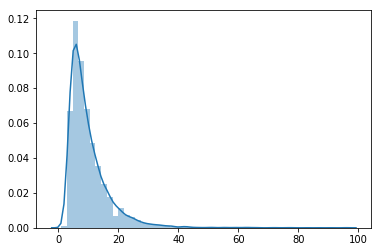

In [12]:
sns.distplot([len(w) for w in origin])

In [ ]:
similarity = [sum([1 if origin[n][i] == augmented[n][i] else 0 for i in range(len(origin[n]))]) / len(origin[n])
              for n in range(len(origin))]

In [ ]:
similarity[:5]

In [11]:
import seaborn as sns

In [ ]:
sns.distplot(similarity)

In [ ]:
similarity.count(1.) * 100 / len(similarity)

In [ ]:
full_sim_indexes = [w for w in range(len(similarity)) if similarity[w] == 1.]

In [ ]:
origin[full_sim_indexes[0]]

In [ ]:
origin[full_sim_indexes[1]]

In [ ]:
origin[full_sim_indexes[2]]

In [ ]:
origin[full_sim_indexes[6]]